In [51]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import screed
import seaborn as sns
from sencha.compare_kmer_content import kmerize, kmerize_and_jaccard, compare_nucleotide_seqs
from sencha.sequence_encodings import encode_nucleotide

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read fasta records

In [16]:
species_list = 'human', 'mouse'

records = {}

for species in species_list:
    record = list(screed.open(f'/Users/olgabot/code/sencha/tests/data/xist_{species}.fasta'))[0]
    records[species] = record
# records

In [17]:
alphabets = 'dna', 'amino-keto', 'purine-pyrimidine', 'weak-strong'

encoded = defaultdict(dict)

for alphabet in alphabets:
    for species, record in records.items():
        encoded[alphabet][species] = encode_nucleotide(record['sequence'], alphabet)

In [34]:
id1_seq1 = 'human', records['human']['sequence']
id2_seq2 = 'mouse', records['mouse']['sequence']

In [35]:
random.seed(2020)

dna_shuffled = {
    species: 
        ''.join(random.sample(record['sequence'], k=len(record['sequence'])))
    for species, record in records.items()
}
id1_seq1_shuffled = 'human', dna_shuffled['human']
id2_seq2_shuffled = 'mouse', dna_shuffled['mouse']

In [81]:
ksizes = np.arange(5, 33, 2)

xist_similarities = compare_nucleotide_seqs(id1_seq1, id2_seq2, ksizes)
xist_similarities['sequence'] = 'xist'
xist_similarities.head()

,id1,id2,ksize,jaccard,alphabet,sequence
0,human,mouse,5,1.000000,purine_pyrimidine,xist
1,human,mouse,7,1.000000,purine_pyrimidine,xist
2,human,mouse,9,1.000000,purine_pyrimidine,xist
3,human,mouse,11,0.997054,purine_pyrimidine,xist
4,human,mouse,13,0.832853,purine_pyrimidine,xist


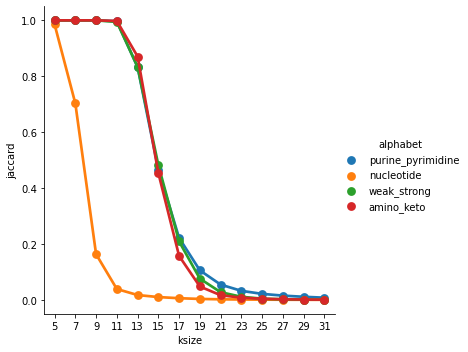

In [82]:
sns.catplot('ksize', 'jaccard', data=xist_similarities, hue='alphabet', kind='point')

In [83]:
shuffled_similarities = compare_nucleotide_seqs(
    id1_seq1_shuffled, id2_seq2_shuffled, ksizes)
shuffled_similarities['sequence'] = 'shuffled'
shuffled_similarities.head()

,id1,id2,ksize,jaccard,alphabet,sequence
0,human,mouse,5,1.000000,purine_pyrimidine,shuffled
1,human,mouse,7,1.000000,purine_pyrimidine,shuffled
2,human,mouse,9,1.000000,purine_pyrimidine,shuffled
3,human,mouse,11,1.000000,purine_pyrimidine,shuffled
4,human,mouse,13,0.903158,purine_pyrimidine,shuffled


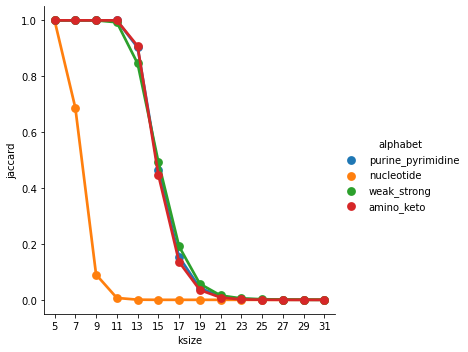

In [84]:
sns.catplot('ksize', 'jaccard', data=shuffled_similarities, hue='alphabet', kind='point')

In [85]:
shuffled_jaccard = shuffled_similarities.set_index(['alphabet', 'ksize'])['jaccard']
xist_jaccard = xist_similarities.set_index(['alphabet', 'ksize'])['jaccard']

jaccard_diff = xist_jaccard - shuffled_jaccard
jaccard_diff_df = jaccard_diff.reset_index()

y = '$\Delta$ Jaccard'
jaccard_diff_df = jaccard_diff_df.rename(columns={'jaccard': y})
print(jaccard_diff_df.shape)
jaccard_diff_df.head()

(56, 3)


,alphabet,ksize,$\Delta$ Jaccard
0,purine_pyrimidine,5,0.000000
1,purine_pyrimidine,7,0.000000
2,purine_pyrimidine,9,0.000000
3,purine_pyrimidine,11,-0.002946
4,purine_pyrimidine,13,-0.070304


In [98]:
4**9

262144

In [99]:
2**17

131072

In [86]:
rows = jaccard_diff_df[y] > 0.04
jaccard_diff_df.loc[rows]

,alphabet,ksize,$\Delta$ Jaccard
6,purine_pyrimidine,17,0.069548
7,purine_pyrimidine,19,0.063784
8,purine_pyrimidine,21,0.044075
16,nucleotide,9,0.074049


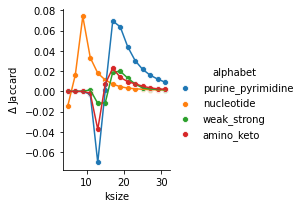

In [87]:

g = sns.FacetGrid(data=jaccard_diff_df, hue='alphabet')
g.map(sns.scatterplot, 'ksize', y)
g.map(plt.plot, 'ksize', y)
g.add_legend()

## Shuffle many times

In [72]:
random.seed(2020)

dfs = []

for i in tqdm(range(100)):

    dna_shuffled = {
        species: 
            ''.join(random.sample(record['sequence'], k=len(record['sequence'])))
        for species, record in records.items()
    }
    id1_seq1_shuffled = 'human', dna_shuffled['human']
    id2_seq2_shuffled = 'mouse', dna_shuffled['mouse']

    shuffled_similarities = compare_nucleotide_seqs(
        id1_seq1_shuffled, id2_seq2_shuffled, ksizes)
    shuffled_similarities['sequence'] = 'shuffled'
    
    shuffled_jaccard = shuffled_similarities.set_index(['alphabet', 'ksize'])['jaccard']
    xist_jaccard = xist_similarities.set_index(['alphabet', 'ksize'])['jaccard']

    jaccard_diff = xist_jaccard - shuffled_jaccard
    df = jaccard_diff.reset_index()

    y = '$\Delta$ Jaccard'
    df = df.rename(columns={'jaccard': y})
    df['iteration'] = i
    dfs.append(df)
jaccard_diff_distributions = pd.concat(dfs)
print(jaccard_diff_distributions.shape)
jaccard_diff_distributions.head()

(5600, 4)


,alphabet,ksize,$\Delta$ Jaccard,iteration
0,purine_pyrimidine,5,0.000000,0
1,purine_pyrimidine,7,0.000000,0
2,purine_pyrimidine,9,0.000000,0
3,purine_pyrimidine,11,-0.002457,0
4,purine_pyrimidine,13,-0.056209,0


In [75]:
# jaccard_diff_distributions = jaccard_diff_distributions.loc[jaccard_diff_distributions.ksize != 14]

In [95]:
# sns.stripplot?

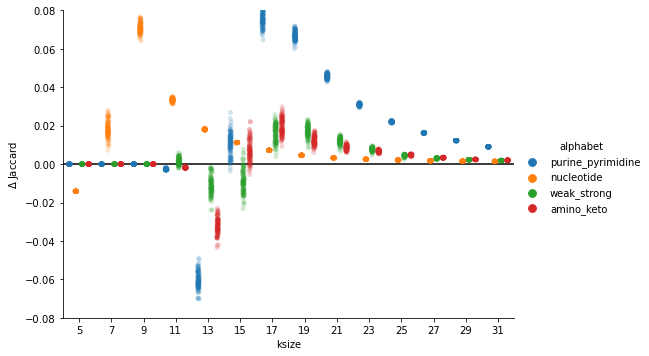

In [96]:
g = sns.catplot('ksize', y, data=jaccard_diff_distributions, 
            hue='alphabet', kind='strip', aspect=1.5, dodge=True, alpha=0.2)
g.set(ylim=(-0.08, 0.08))
for ax in g.axes.flat:
    ax.axhline(0, color='k')
    

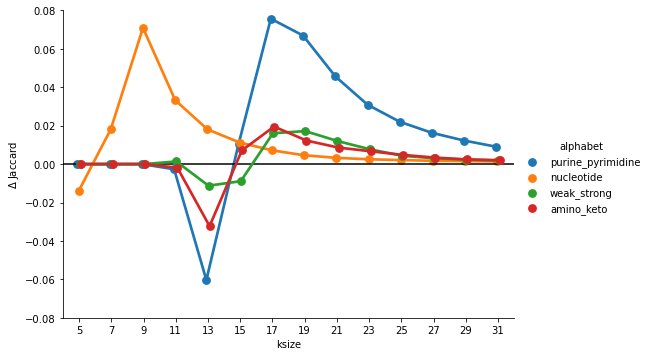

In [97]:
g = sns.catplot('ksize', y, data=jaccard_diff_distributions, 
            hue='alphabet', kind='point', aspect=1.5, dodge=True)
g.set(ylim=(-0.08, 0.08))
for ax in g.axes.flat:
    ax.axhline(0, color='k')
    

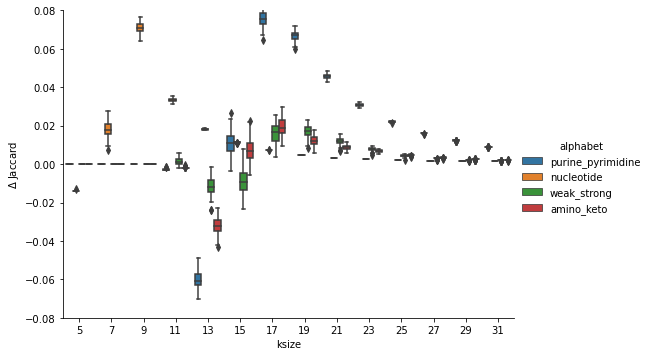

In [92]:
g = sns.catplot('ksize', y, data=jaccard_diff_distributions, 
            hue='alphabet', kind='box', aspect=1.5)
g.set(ylim=(-0.08, 0.08))
g.savefig('')